In [ ]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425344 sha256=6099c6231ad970c97429905ccaad697022e57c3e50d34883e4194302f4ef0479
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [ ]:
import pyspark
from pyspark.sql import SparkSession
spark=SparkSession.builder.appName('Fire DF').getOrCreate()

In [ ]:
from pyspark.sql.functions import *
from pyspark.sql.types import *

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
df=spark.read.csv('sf-fire-calls.csv',header=True,inferSchema=True)

In [ ]:

df.show()

+----------+------+--------------+----------------+----------+----------+--------------------+--------------------+--------------------+----+-------+---------+-----------+----+----------------+--------+-------------+-------+-------------+---------+--------------+--------------------------+----------------------+------------------+--------------------+--------------------+-------------+---------+
|CallNumber|UnitID|IncidentNumber|        CallType|  CallDate| WatchDate|CallFinalDisposition|       AvailableDtTm|             Address|City|Zipcode|Battalion|StationArea| Box|OriginalPriority|Priority|FinalPriority|ALSUnit|CallTypeGroup|NumAlarms|      UnitType|UnitSequenceInCallDispatch|FirePreventionDistrict|SupervisorDistrict|        Neighborhood|            Location|        RowID|    Delay|
+----------+------+--------------+----------------+----------+----------+--------------------+--------------------+--------------------+----+-------+---------+-----------+----+----------------+--------+

In [ ]:
df=df.withColumn('Date',to_date(col('callDate'),'dd/mm/yyyy')).drop('callDate')

In [ ]:
clean_df=df.withColumn('Year',year(col('Date'))).withColumn('Month',month(col('Date'))).withColumn('Week',weekofyear(col('Date')))
clean_df.show()

+----------+------+--------------+----------------+----------+--------------------+--------------------+--------------------+----+-------+---------+-----------+----+----------------+--------+-------------+-------+-------------+---------+--------------+--------------------------+----------------------+------------------+--------------------+--------------------+-------------+---------+----------+----+-----+----+
|CallNumber|UnitID|IncidentNumber|        CallType| WatchDate|CallFinalDisposition|       AvailableDtTm|             Address|City|Zipcode|Battalion|StationArea| Box|OriginalPriority|Priority|FinalPriority|ALSUnit|CallTypeGroup|NumAlarms|      UnitType|UnitSequenceInCallDispatch|FirePreventionDistrict|SupervisorDistrict|        Neighborhood|            Location|        RowID|    Delay|      Date|Year|Month|Week|
+----------+------+--------------+----------------+----------+--------------------+--------------------+--------------------+----+-------+---------+-----------+----+-----

In [ ]:
df.count()

8782

In [ ]:
clean_df.select('Year').groupBy('Year').count().orderBy('Year',ascending=True).show()

+----+-----+
|Year|count|
+----+-----+
|2002| 7855|
|2003|  927|
+----+-----+



In [ ]:
clean_df.select('callType').where(col('Year')=='2018').distinct().show(truncate=False)

+--------+
|callType|
+--------+
+--------+



In [ ]:

#Which week in the year in 2018 had the most fire calls?
fire_calls_2018 = clean_df.filter(col('Year') == 2018)
max_week = fire_calls_2018.groupBy('Week').count()
max_count = max_week.agg({'count': 'max'}).collect()[0][0]
result = max_week.filter(col('count') == max_count).select('Week')
result.show()

+----+
|Week|
+----+
+----+



In [ ]:
clean_df.groupBy('Year','Month').count().show()

+----+-----+-----+
|Year|Month|count|
+----+-----+-----+
|2003|    1|  927|
|2002|    1| 7855|
+----+-----+-----+



In [ ]:
selected_year = 2018
filtered_data = clean_df.filter(col('Year') == selected_year)
monthly_report = filtered_data.groupBy('Month', 'CallType').count()
monthly_report.show()

+-----+--------+-----+
|Month|CallType|count|
+-----+--------+-----+
+-----+--------+-----+



In [ ]:
#consider month and if particular month then estimate the season
#UDF->user defined function to register all the method calls
def mapSeason(data):
  if 2 < data < 6:
    return 'Spring'
  elif 5 < data <9:
    return 'Summer'
  elif 8 < data < 12:
    return 'Autumn'
  else:
    return 'Winter'
seasonUDF=udf(mapSeason,StringType())
clean_df=clean_df.withColumn('Season',seasonUDF(col('Month')))
clean_df.show()


+----------+------+--------------+----------------+----------+--------------------+--------------------+--------------------+----+-------+---------+-----------+----+----------------+--------+-------------+-------+-------------+---------+--------------+--------------------------+----------------------+------------------+--------------------+--------------------+-------------+---------+----------+----+-----+----+------+
|CallNumber|UnitID|IncidentNumber|        CallType| WatchDate|CallFinalDisposition|       AvailableDtTm|             Address|City|Zipcode|Battalion|StationArea| Box|OriginalPriority|Priority|FinalPriority|ALSUnit|CallTypeGroup|NumAlarms|      UnitType|UnitSequenceInCallDispatch|FirePreventionDistrict|SupervisorDistrict|        Neighborhood|            Location|        RowID|    Delay|      Date|Year|Month|Week|Season|
+----------+------+--------------+----------------+----------+--------------------+--------------------+--------------------+----+-------+---------+--------

In [ ]:
from pyspark.sql.window import Window
from pyspark.sql.functions import rank
filtered_data = clean_df.filter(col('Year') == 2018)
window_spec = Window.partitionBy('Season').orderBy(col('count').desc())
ranked_data = filtered_data.groupBy('Season', 'CallType').count().withColumn("rank", rank().over(window_spec))
top_five_in_each_season = ranked_data.filter(col('rank') <= 5)
top_five_in_each_season.show()

+------+--------+-----+----+
|Season|CallType|count|rank|
+------+--------+-----+----+
+------+--------+-----+----+



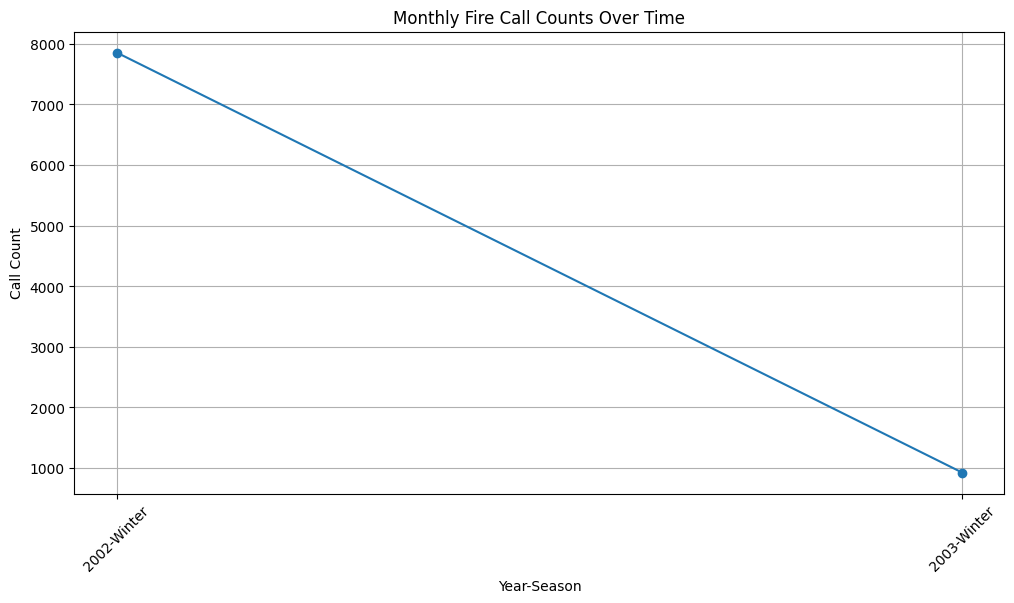

In [ ]:
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
#Whether fire type calls are seasonal?

monthly_call_counts = clean_df.groupBy('Year', 'Season').count().orderBy('Year', 'Season')
monthly_call_counts_pd = monthly_call_counts.toPandas()
plt.figure(figsize=(12, 6))
plt.plot(monthly_call_counts_pd['Year'].astype(str) + '-' + monthly_call_counts_pd['Season'].astype(str), monthly_call_counts_pd['count'], marker='o')
plt.title('Monthly Fire Call Counts Over Time')
plt.xlabel('Year-Season')
plt.ylabel('Call Count')
plt.xticks(rotation=45)
plt.grid()
plt.show()

In [ ]:
filtered_data = clean_df.filter(col('Year') == 2018)
monthly_call_counts = filtered_data.groupBy('Month').count()
max_calls = monthly_call_counts.agg({"count": "max"}).collect()[0][0]
top_months = monthly_call_counts.filter(col("count") == max_calls)
top_months.show()

+-----+-----+
|Month|count|
+-----+-----+
+-----+-----+



In [ ]:
yearly_call_counts = clean_df.groupBy('Year', 'CallType').count()
major_call_type_by_year = yearly_call_counts.groupBy('Year').agg(max('count').alias('MaxCount'))
major_call_type_details = yearly_call_counts.join(
    major_call_type_by_year,
    (yearly_call_counts['Year'] == major_call_type_by_year['Year']) & (yearly_call_counts['count'] == major_call_type_by_year['MaxCount']),
    'inner'
)
result = major_call_type_details.select(col('Year'), 'CallType', 'MaxCount')
result.show()

SyntaxError: ignored

In [ ]:
average_delay_by_call_type = clean_df.groupBy('CallType').agg(avg('Delay').alias('AverageDelay'))
average_delay_by_call_type.show()

+--------------------+------------------+
|            CallType|      AverageDelay|
+--------------------+------------------+
|Elevator / Escala...| 3.800877184210526|
|  Aircraft Emergency| 5.650000016666667|
|              Alarms| 2.839064202002179|
|Odor (Strange / U...|3.5357723643902434|
|Citizen Assist / ...| 4.509050760264899|
|              HazMat|       5.333333425|
|           Explosion|         3.1333334|
|           Oil Spill|       4.425000075|
|        Vehicle Fire|3.2021929526315795|
|  Suspicious Package|          9.483334|
|               Other| 4.934061903825139|
|        Outside Fire| 2.633500002999999|
|   Traffic Collision| 4.565079302222223|
|Gas Leak (Natural...|3.6244444600000003|
|        Water Rescue| 3.748550730434783|
|   Electrical Hazard|7.4644927565217385|
|      Structure Fire| 3.117832842483973|
|Industrial Accidents|3.2666667000000005|
|    Medical Incident|3.7694193558672797|
|          Fuel Spill| 4.051851844444444|
+--------------------+------------

In [ ]:
#Find which calltype has maximum average delay time.
average_delay_by_call_type = clean_df.groupBy('CallType').agg(avg('Delay').alias('AverageDelay'))
max_average_delay_call_type = average_delay_by_call_type.orderBy(col('AverageDelay').desc()).first()
print("Call Type with Maximum Average Delay:")
print("Call Type:", max_average_delay_call_type['CallType'])
print("Average Delay:", max_average_delay_call_type['AverageDelay'])

Call Type with Maximum Average Delay:
Call Type: Suspicious Package
Average Delay: 9.483334


In [ ]:

#Which neighborhood in San Francisco generated the most fire calls in 2018
neighborhood_call_counts = clean_df.filter((col('Year') == 2018) & (col('Neighborhood').isNotNull())) \
    .groupBy('Neighborhood').count()
max_calls_neighborhood = neighborhood_call_counts.orderBy(col('count').desc()).first()
print("Neighborhood:", max_calls_neighborhood['Neighborhood'])
print("Number of Fire Calls:", max_calls_neighborhood['count'])


TypeError: ignored

In [ ]:

#Which neighborhoods had the worst response times to fire calls in 2018?
filtered_data = clean_df.filter((col('Year') == 2018) & (col('Delay').isNotNull()))
neighborhood_response_time = filtered_data.groupBy('Neighborhood').agg(avg('Delay').alias('AverageResponseTime'))
worst_response_time_neighborhoods = neighborhood_response_time.orderBy(col('AverageResponseTime').desc())
worst_response_time_neighborhoods.show()

+------------+-------------------+
|Neighborhood|AverageResponseTime|
+------------+-------------------+
+------------+-------------------+



In [ ]:
#Find out calltype whose average response delay time is maximum, increases, decreases or has no relation over years
average_delay_by_year_calltype = clean_df.groupBy('Year', 'CallType').agg(avg('Delay').alias('AverageDelay'))
pivoted_data = average_delay_by_year_calltype.groupBy('Year').pivot('CallType').agg(avg('AverageDelay')).na.fill(0)
data = pivoted_data.select('Year', 'CallType').orderBy('Year').toPandas()
plt.plot(data['Year'], data['CallType'])
plt.title('Trend of Average Delay for TypeA Over Years')
plt.xlabel('Year')
plt.ylabel('Average Delay')
plt.show()

AnalysisException: ignored

In [ ]:
#For each year find out which city has more calltype

call_type_by_city_year = clean_df.groupBy('Year', 'CallType', 'City').count()
window_spec = Window.partitionBy('Year', 'CallType').orderBy(col('count').desc())
max_call_type_by_city_year = call_type_by_city_year.withColumn('rank', rank().over(window_spec))
max_calls_by_city_year = max_call_type_by_city_year.filter(col('rank') == 1)
max_calls_by_city_year.show()

+----+--------------------+----+-----+----+
|Year|            CallType|City|count|rank|
+----+--------------------+----+-----+----+
|2002|  Aircraft Emergency| SFO|    5|   1|
|2002|              Alarms|  SF|  805|   1|
|2002|Citizen Assist / ...|  SF|  136|   1|
|2002|   Electrical Hazard|  SF|   20|   1|
|2002|Elevator / Escala...|  SF|   19|   1|
|2002|          Fuel Spill|  SF|    6|   1|
|2002|Gas Leak (Natural...|  SF|   14|   1|
|2002|              HazMat|  SF|    4|   1|
|2002|Industrial Accidents|  SF|    6|   1|
|2002|    Medical Incident|  SF| 4872|   1|
|2002|Odor (Strange / U...|  SF|   36|   1|
|2002|           Oil Spill|  SF|    3|   1|
|2002|               Other|  SF|  166|   1|
|2002|        Outside Fire|  SF|   87|   1|
|2002|Smoke Investigati...|  SF|   26|   1|
|2002|      Structure Fire|  SF| 1524|   1|
|2002|  Suspicious Package|  SF|    1|   1|
|2002|   Traffic Collision|  SF|   34|   1|
|2002|Train / Rail Inci...|  SF|    4|   1|
|2002|        Vehicle Fire|  SF|

In [ ]:
#For each year find out which city has more calltype

call_type_by_city_year = clean_df.groupBy('Year', 'CallType', 'City').count()
window_spec = Window.partitionBy('Year', 'CallType').orderBy(col('count').desc())
max_call_type_by_city_year = call_type_by_city_year.withColumn('rank', rank().over(window_spec))
max_calls_by_city_year = max_call_type_by_city_year.filter(col('rank') == 1)
max_calls_by_city_year.show()

+----+--------------------+----+-----+----+
|Year|            CallType|City|count|rank|
+----+--------------------+----+-----+----+
|2002|  Aircraft Emergency| SFO|    5|   1|
|2002|              Alarms|  SF|  805|   1|
|2002|Citizen Assist / ...|  SF|  136|   1|
|2002|   Electrical Hazard|  SF|   20|   1|
|2002|Elevator / Escala...|  SF|   19|   1|
|2002|          Fuel Spill|  SF|    6|   1|
|2002|Gas Leak (Natural...|  SF|   14|   1|
|2002|              HazMat|  SF|    4|   1|
|2002|Industrial Accidents|  SF|    6|   1|
|2002|    Medical Incident|  SF| 4872|   1|
|2002|Odor (Strange / U...|  SF|   36|   1|
|2002|           Oil Spill|  SF|    3|   1|
|2002|               Other|  SF|  166|   1|
|2002|        Outside Fire|  SF|   87|   1|
|2002|Smoke Investigati...|  SF|   26|   1|
|2002|      Structure Fire|  SF| 1524|   1|
|2002|  Suspicious Package|  SF|    1|   1|
|2002|   Traffic Collision|  SF|   34|   1|
|2002|Train / Rail Inci...|  SF|    4|   1|
|2002|        Vehicle Fire|  SF|

In [ ]:
#Is there a correlation between neighborhood, zip code, and number of fire calls
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.sql.types import DoubleType
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

# Create a Spark session
aggregated_data = clean_df.groupBy('Neighborhood', 'ZipCode').count()
pivoted_data = aggregated_data.groupBy('Neighborhood').pivot('ZipCode').count().na.fill(0)
assembler = VectorAssembler(inputCols=pivoted_data.columns[1:], outputCol="features")
feature_vector = assembler.transform(pivoted_data)
correlation_matrix = Correlation.corr(feature_vector, "features", method="pearson")
correlation_array = correlation_matrix.collect()[0]["pearson(features)"].toArray()
for i, neighborhood in enumerate(pivoted_data.select('Neighborhood').rdd.map(lambda x: x[0]).collect()):
    for j, zip_code in enumerate(pivoted_data.columns[1:]):
        correlation = correlation_array[i][j]
        print(f"Correlation between {neighborhood} and {zip_code}: {correlation}")

Correlation between Inner Sunset and null: 1.0
Correlation between Inner Sunset and 94102: -0.06375767130633382
Correlation between Inner Sunset and 94103: -0.07575540190785703
Correlation between Inner Sunset and 94104: -0.03492151478847891
Correlation between Inner Sunset and 94105: -0.024390243902439022
Correlation between Inner Sunset and 94107: -0.057410616663949914
Correlation between Inner Sunset and 94108: -0.043314808182421
Correlation between Inner Sunset and 94109: -0.0698430295769578
Correlation between Inner Sunset and 94110: -0.06375767130633382
Correlation between Inner Sunset and 94111: -0.043314808182421
Correlation between Inner Sunset and 94112: -0.06375767130633382
Correlation between Inner Sunset and 94114: -0.06375767130633382
Correlation between Inner Sunset and 94115: -0.057410616663949914
Correlation between Inner Sunset and 94116: -0.043314808182421
Correlation between Inner Sunset and 94117: -0.0698430295769578
Correlation between Inner Sunset and 94118: -0.0

IndexError: ignored